In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from equinox.nn._attention import dot_product_attention_weights
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
cd roma/

/Users/thales/roma


In [3]:
# ROMA-B, KM-3M: 1738682419
# ROMA-L, KM-3M: 1738555752
# ROMA-H, KM-3M: 1738616224
# ROMA-B, BD-3M: 1738496991
# ROMA-L, BD-3M: 1738363431
# ROMA-H, BD-3M: 1738427104

In [4]:
#run train.py --steps 0 --log_path 1738682419 --path 1722285916 --steps 0 --dec_width 1024 --p_basis 2048

In [5]:
#run train.py --steps 0 --log_path 1738555752 --path 1722285916 --steps 0 --dec_width 2048 --p_basis 2048

In [6]:
run train.py --steps 0 --log_path 1738616224 --path 1722285916 --steps 0 --dec_width 2560 --p_basis 2560


 time_stamp = 1738963864

 data_path: ../data/x_K1.7.0.00_N3153586_c0.75_t1722285916.parquet
 adj_path: ../data/edges_N3153586_c0.75_t1722285916.parquet
 pe_path: ../data/pe_dim1024_N3153586_c0.75_t1722285916.parquet

 Reading PE (LapPE, node2vec) from pe_path... Done.

 Reading graph from data_adj... Done.

 Reading timeseries from data_path... Done.

 Initializing loader and sampling test batch... Done.

 Initializing loader and sampling first training batch... Done.


 MODULE: MODEL[DIMS](curv)
  encoder: HGCN[256, 512]Poi(c=0.125)
  pool:
   pool_0: HGCN[512, 64]
  embed:
   embed_0: HGCN[512, 512]
  decoder: Operator[8192, 6*[2560], 7680] -> [3]
  pde: emergent/Operator[8192, 6*[2560], 7680] -> [1]
    nonlinear[dec,pde]: False,False
    func_space: GRF(l=1.0)
    branch/trunk nets: Transformer/Res
    dual pe: Sequential
    pos_emb_var = [0.25, 1.0], level_emb_var = [1.0]
    time_enc: fourier[2048][t_var=0.0001,x_var=0.0001]

  NUM_PARAMS = 1 B


 x[train] = (3153074, 800), ed

In [7]:
#run train.py --steps 0 --log_path 1738496991 --path 1736885910 --pde burgers --steps 0 --w_pool 1 --manifold Euclidean --pe_embed_dim 0 --dec_width 1024 --level_emb_var 1.0 --pos_emb_var 1.0 --func_pos_emb 0

In [8]:
#run train.py --steps 0 --log_path 1738363431 --path 1736885910 --pde burgers --steps 0 --w_pool 1 --manifold Euclidean --pe_embed_dim 0 --dec_width 2048 --level_emb_var 1.0 --pos_emb_var 1.0 --func_pos_emb 0

In [9]:
#run train.py --steps 0 --log_path 1738427104 --path 1736885910 --pde burgers --steps 0 --w_pool 1 --manifold Euclidean --pe_embed_dim 0 --dec_width 2560 --level_emb_var 1.0 --pos_emb_var 1.0 --func_pos_emb 0

In [10]:
batch, loader = get_next_batch(loader, args, data_train)
x_b, adj_b, pe_b = x_test, adj_test, pe_test
#x_b, adj_b, pe_b = pad_graph(x=x[batch.idx.numpy()], adj=batch.edge_index.numpy(), pe=pe[batch.idx.numpy()], x_size=args.batch_size)
#x, adj, pe = pad_graph(batch.x.numpy(), batch.edge_index.numpy(), batch.pe.numpy(), x_size=args.batch_size)

def get_batch(x_b):
    ti = jnp.linspace(args.kappa, T - args.kappa , 20).reshape(-1,1) #jnp.array([4.,5.]).reshape(-1,1)#
    idx = ti.astype(int)
    taus = jnp.arange(1, 1+args.tau_max, 1).astype(int)
    bundles = idx + taus
    yi = x_b[:,bundles].T
    yi = jnp.swapaxes(yi,0,1)
    xi,_ = _batch(x_b, pe_b, idx)
    #xi = _batch(x, pe, idx, sigma=1e-4)

    return xi, yi

def xy_batch(loader):
    batch, loader = get_next_batch(loader, args, data_train)
    x, adj, pe = pad_graph(batch.x.numpy(), batch.edge_index.numpy(), batch.pe.numpy(), x_size=args.batch_size)
    xi, yi = batch(x)
    return xi,yi,loader


xi, yi = get_batch(x_b)

ti = jnp.linspace(args.kappa, T - args.kappa , 20).reshape(-1,1)
idx = ti.astype(int)
#x1, y1 = _batch(x_b, pe_b, idx, key=key)

xi.shape,yi.shape

((20, 512, 1088), (20, 1, 512))

In [11]:
xi[0].shape, adj_b.shape

((512, 1088), (2, 8192))

In [12]:
#def _fwd(ub, adj, t, y, key, mode='train'):
keys = jr.split(prng(),5)
z = model.encode(xi[0], adj_b, key=keys[0])
z, y, loss_pool, S, A = model.renorm(z, adj_b, yi[0], key=keys[1])
x = jnp.zeros((z.shape[0], model.x_dim))
t_ = ti[0] * jnp.ones((z.shape[0],1))
tx = jnp.concatenate([t_,x], axis=-1)
#z_dec, z_pde = model.branch(z, keys[2])

b,z = z[:,:model.kappa],z[:,model.kappa:]
b = model.decoder.func_space(b, keys[0])
pe = jax.vmap(model.decoder.func_pe)(z)
b_dec, attn = model.decoder.branch(b, keys[1], pe=pe, inspect=True)


In [13]:
attn_block = model.decoder.branch.attention_blocks[0]
attn_blocks = model.decoder.branch.attention_blocks
branch = model.decoder.branch

In [14]:
x = jax.vmap(branch.lin1)(b)
x = jax.vmap(attn_block.layer_norm1)(x)

In [15]:
k = attn_block.attention._project(attn_block.attention.key_proj, x)
q = attn_block.attention._project(attn_block.attention.query_proj, x)
v = attn_block.attention._project(attn_block.attention.value_proj, x)
attn_weights = jax.vmap(dot_product_attention_weights, in_axes=1)(k,q)
(k.shape, q.T.shape, v.shape), '->', attn_weights.shape

(((576, 8, 320), (320, 8, 576), (576, 8, 320)), '->', (8, 576, 576))

In [16]:
# coarse scale weighted attention
cswa = lambda a: (a[:512,512:]).mean()

In [17]:
#wd = lambda a: {1:spwa(a,1), 2:spwa(a,2), 3:spwa(a,3), 4:spwa(a,4)}
wd = lambda a: cswa(a)

In [18]:
attn = np.array(attn)

In [19]:
attn.shape

(7, 8, 576, 576)

In [20]:
pd.DataFrame(jax.vmap(jax.vmap(wd))(attn)).T

,0,1,2,3,4,5,6
0,3.773196e-05,0.000047,0.005467,0.005450,0.008701,0.005166,0.001848
1,2.461830e-05,0.002323,0.000019,0.003522,0.001886,0.007460,0.004711
2,9.570594e-08,0.003232,0.002675,0.002316,0.003756,0.006432,0.003859
3,3.533158e-04,0.000140,0.007843,0.002103,0.002722,0.003739,0.002398
4,8.778356e-03,0.002229,0.006641,0.004698,0.002243,0.004073,0.002849
5,9.506065e-05,0.000977,0.002341,0.000838,0.002915,0.004011,0.002889
6,2.469156e-04,0.000505,0.000836,0.001518,0.001170,0.001772,0.002994
7,9.149962e-05,0.005243,0.005527,0.003461,0.003733,0.006100,0.004012


In [21]:
_df = pd.DataFrame(jax.vmap(jax.vmap(wd))(attn)).T
_df = _df.rename_axis("layer", axis="columns")
_df = _df.rename_axis("head", axis="index")
df = _df.melt(col_level=0)
df.loc[:,'layer'] += 1

df.to_csv(f'ms_attn_{args.log_path}.csv')

Text(0.5, 1.0, 'Multiscale attention ')

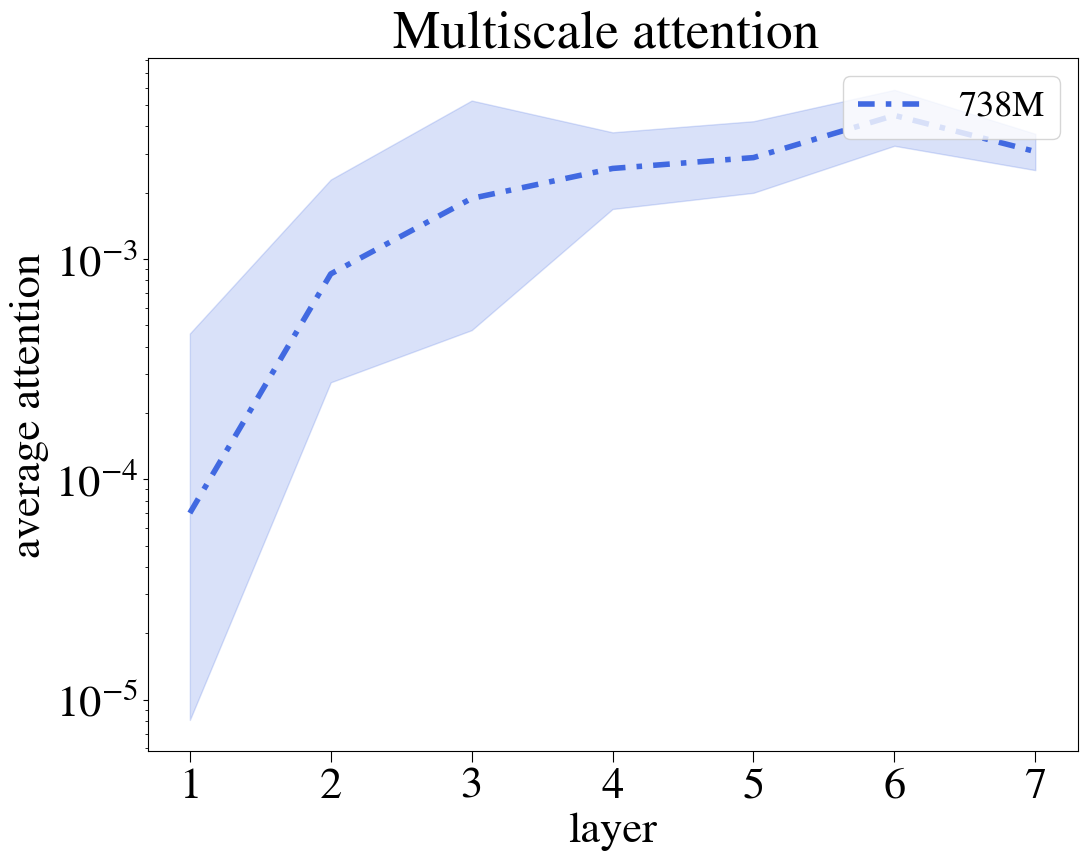

In [22]:
c1 = ['#d62728','royalblue','cadetblue','#9467bd','teal','crimson']
ls=[(0,(1,1)),(0, (3, 2, 1, 2)),(0, (5, 2.)), (0, (3, 1, 1, 1, 1, 1))]
lw = 4
plt.rcParams['font.size'] = 32; plt.rcParams['xtick.major.size'] = 8
plt.rcParams['font.family'] = 'STIXgeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = 'Computer Modern Roman'

f, ax = plt.subplots(figsize=(12, 9))
ax.set(yscale="log")
plot = sns.lineplot(data=df,ax=ax, x="layer", y='value',label='738M',color=c1[1],linestyle=ls[1],lw=lw)
#sns.scatterplot(df[0],ax=ax, x="layer", y='value',label='$d_{ij}=1$',color=c1[0],linestyle=ls[0]))
#sns.lineplot(data=df[1], x="layer", y='value',label='$d_{ij}=2$',color=c1[1],linestyle=ls[1])
#sns.lineplot(data=df[2], x="layer", y='value',label='$d_{ij}=3$',color=c1[2],linestyle=ls[2])
#sns.lineplot(data=df[3], x="layer", y='value',label='$d_{ij}=4$',color=c1[3],linestyle=ls[3])
ax.set_ylabel(r'average attention')
ax.set_xticks([1,2,3,4,5,6,7])
plot.legend(loc=1, prop={'size': 26})
#egend = plt.legend(handles=[one, two, three], title="title",
                    #loc=4, fontsize='small', fancybox=True)
plt.title('Multiscale attention ')

In [23]:
# ROMA-B, KM-3M: 1738682419
# ROMA-L, KM-3M: 1738555752
# ROMA-H, KM-3M: 1738616224

# ROMA-B, BD-3M: 1738496991
# ROMA-L, BD-3M: 1738363431
# ROMA-H, BD-3M: 1738427104

In [24]:
%ls

LICENSE                 attn_1738682419.csv     ms_attn_1738427104.csv
README.md               batch.sh                ms_attn_1738496991.csv
__init__.py             config.py               ms_attn_1738555752.csv
__pycache__/            experiments.sh          ms_attn_1738616224.csv
args/                   expvar_10.pdf           ms_attn_1738682419.csv
attn_10.pdf             figures/                nn/
attn_1738363431.csv     fsa_bd.pdf              pca_10.pdf
attn_1738427104.csv     fsa_km.pdf              requirements.txt
attn_1738496991.csv     gen_args.py             set_env.sh*
attn_1738555752.csv     lib/                    train.py
attn_1738616224.csv     ms_attn_1738363431.csv


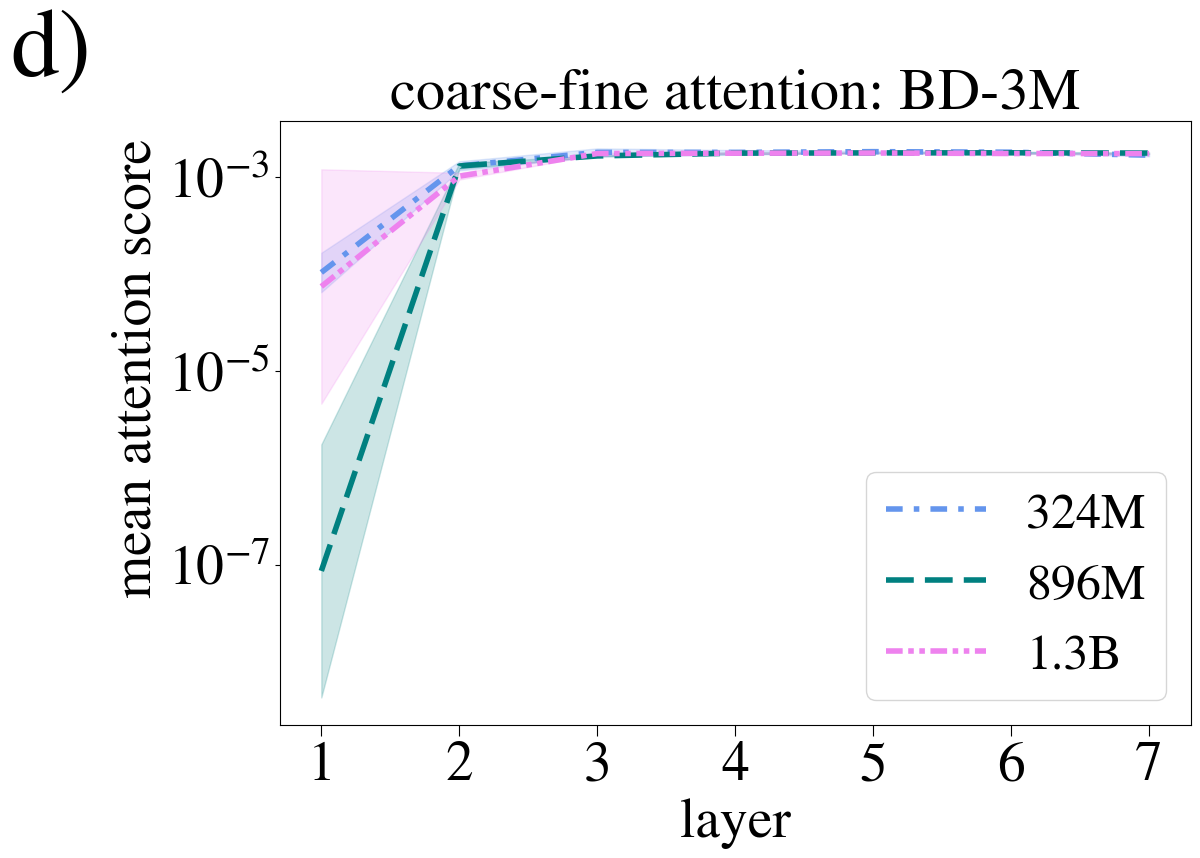

In [65]:
df1 = pd.read_csv('ms_attn_1738496991.csv',index_col=0)
df2 = pd.read_csv('ms_attn_1738363431.csv',index_col=0)
df3 = pd.read_csv('ms_attn_1738427104.csv',index_col=0)

c1 = ['#d62728','royalblue','cadetblue','#9467bd','cornflowerblue','teal','violet']
ls=[(0,(1,1)),(0, (3, 2, 1, 2)),(0, (5, 2.)), (0, (3, 1, 1, 1, 1, 1))]
lw = 4
plt.rcParams['font.size'] = 40; plt.rcParams['xtick.major.size'] = 8
plt.rcParams['font.family'] = 'STIXgeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = 'Computer Modern Roman'


f, ax = plt.subplots(figsize=(12, 9))
ax.set(yscale="log")
plot = sns.lineplot(data=df1,ax=ax, x="layer", y='value',label='324M',color=c1[4], linestyle=ls[1], lw=lw, errorbar='se')
sns.lineplot(data=df2,ax=ax, x="layer", y='value',label='896M',color=c1[5], linestyle=ls[2], lw=lw, errorbar='se')
sns.lineplot(data=df3,ax=ax, x="layer", y='value',label='1.3B',color=c1[6], linestyle=ls[3], lw=lw, errorbar='se')
#sns.scatterplot(df[0],ax=ax, x="layer", y='value',label='$d_{ij}=1$',color=c1[0],linestyle=ls[0]))
#sns.lineplot(data=df[1], x="layer", y='value',label='$d_{ij}=2$',color=c1[1],linestyle=ls[1])
#sns.lineplot(data=df[2], x="layer", y='value',label='$d_{ij}=3$',color=c1[2],linestyle=ls[2])
#sns.lineplot(data=df[3], x="layer", y='value',label='$d_{ij}=4$',color=c1[3],linestyle=ls[3])
ax.set_ylabel(r'        mean attention score')
ax.set_xticks([1,2,3,4,5,6,7])
f.text(.0, .95, 'd)', ha='center', va='center', fontsize=70)
plot.legend(loc=4, prop={'size': 36},fontsize='large')
#egend = plt.legend(handles=[one, two, three], title="title",
                    #loc=4, fontsize='small', fancybox=True)
plt.title('coarse-fine attention: BD-3M',fontsize=42)
plt.tight_layout()
plt.savefig('msa_bd.pdf',bbox_inches='tight')

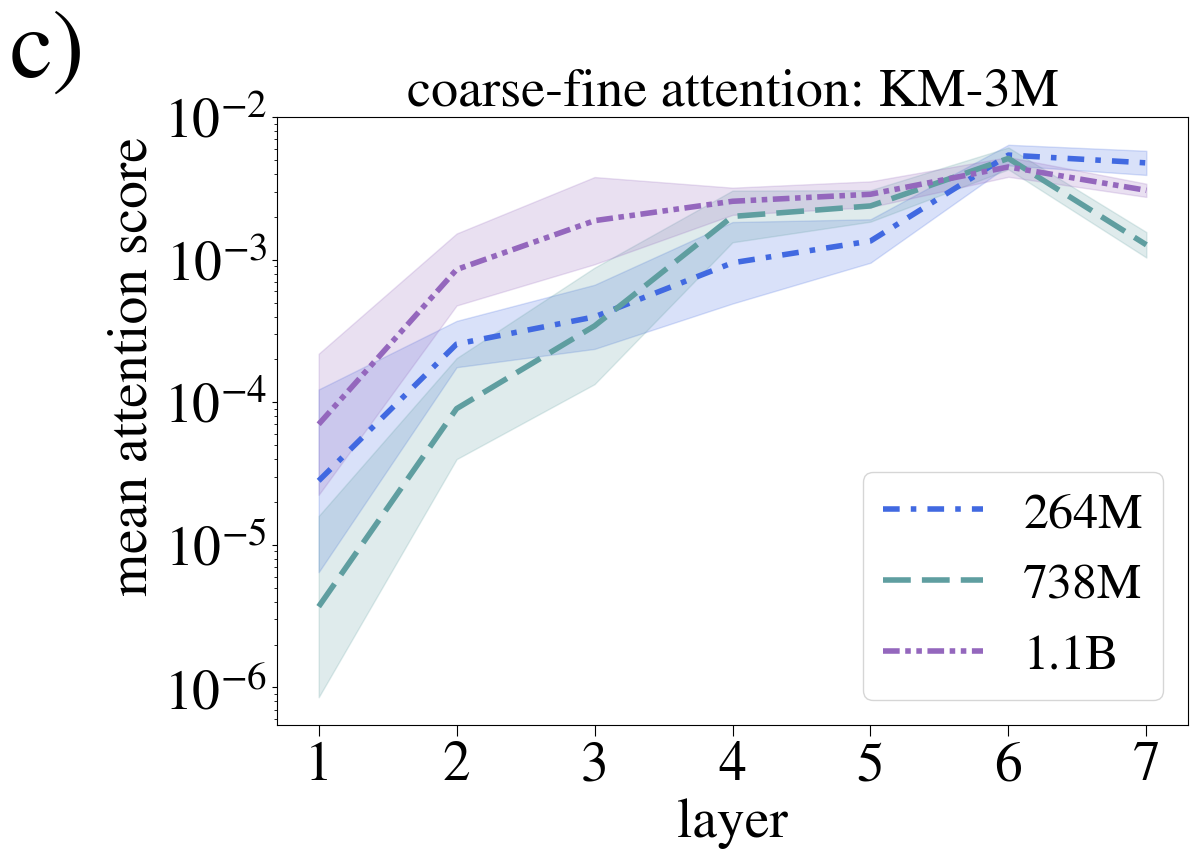

In [66]:
df1 = pd.read_csv('ms_attn_1738682419.csv',index_col=0)
df2 = pd.read_csv('ms_attn_1738555752.csv',index_col=0)
df3 = pd.read_csv('ms_attn_1738616224.csv',index_col=0)

c1 = ['#d62728','royalblue','cadetblue','#9467bd','teal','crimson']
ls=[(0,(1,1)),(0, (3, 2, 1, 2)),(0, (5, 2.)), (0, (3, 1, 1, 1, 1, 1))]
lw = 4
plt.rcParams['font.size'] = 40; plt.rcParams['xtick.major.size'] = 8
plt.rcParams['font.family'] = 'STIXgeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = 'Computer Modern Roman'


f, ax = plt.subplots(figsize=(12, 9))
ax.set(yscale="log")
plot = sns.lineplot(data=df1,ax=ax, x="layer", y='value',label='264M',color=c1[1], linestyle=ls[1], lw=lw, errorbar='se')
sns.lineplot(data=df2,ax=ax, x="layer", y='value',label='738M',color=c1[2], linestyle=ls[2], lw=lw, errorbar='se')
sns.lineplot(data=df3,ax=ax, x="layer", y='value',label='1.1B',color=c1[3], linestyle=ls[3], lw=lw, errorbar='se')
#sns.scatterplot(df[0],ax=ax, x="layer", y='value',label='$d_{ij}=1$',color=c1[0],linestyle=ls[0]))
#sns.lineplot(data=df[1], x="layer", y='value',label='$d_{ij}=2$',color=c1[1],linestyle=ls[1])
#sns.lineplot(data=df[2], x="layer", y='value',label='$d_{ij}=3$',color=c1[2],linestyle=ls[2])
#sns.lineplot(data=df[3], x="layer", y='value',label='$d_{ij}=4$',color=c1[3],linestyle=ls[3])
ax.set_ylabel(r'        mean attention score')
ax.set_xticks([1,2,3,4,5,6,7])
f.text(.0, .95, 'c)', ha='center', va='center', fontsize=70)
plot.legend(loc=4, prop={'size': 36},fontsize='large')
#egend = plt.legend(handles=[one, two, three], title="title",
                    #loc=4, fontsize='small', fancybox=True)
plt.title('coarse-fine attention: KM-3M',fontsize=39)
plt.tight_layout()
plt.savefig('msa_km.pdf',bbox_inches='tight')